In [2]:
import torch
from torch.utils.data import Dataset, DataLoader

from PIL import Image

import numpy as np

import os


# %%
class CitiesData(Dataset):
    def __init__(self, dataParentFolder: str, dataIdxs: list, transform = None, batch_size=128):
        self.dataParentFolder = dataParentFolder
        self.transform = transform

        imagePaths = []
        for city in os.listdir(dataParentFolder):
            path = os.path.join(dataParentFolder, city)
            imagePaths.extend([os.path.join(path, imageFile).replace("\\", "/") for imageFile in os.listdir(path)])
            
        self.imagePaths = np.array(imagePaths)[dataIdxs]

    def __len__(self):
        return len(self.imagePaths)

    def __getitem__(self, idx: int):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        imagePath = self.imagePaths[idx]
        pathSplits = imagePath.split("/")
        city = pathSplits[2]
        longitude, latitude = pathSplits[3].split(",")
        latitude = latitude.split(".jpg")[0]

        image = Image.open(imagePath)
        if self.transform:
            image = self.transform(image)
    
        return image, city, float(longitude), float(latitude)

# %%
def getCitiesDataLoader(dataParentFolder: str, batchSize: int = 128, transforms = None):
    cityIdxs = [0]
    totalPoints = 0
    for city in os.listdir(dataParentFolder):
        totalPoints += len(os.listdir(os.path.join(dataParentFolder, city)))
        cityIdxs.append(totalPoints)

    trainIdxs = []
    testIdxs = []
    for i in range(len(cityIdxs) - 1):
        start = cityIdxs[i]
        stop = cityIdxs[i + 1]

        num_train = int(np.round((stop - start) / 100 * 90))
        # Shuffle all training stimulus images
        idxs = np.arange(start, stop)

        np.random.shuffle(idxs)

        # Assign 90% of the shuffled stimulus images for each city to the training partition,
        # and 10% to the test partition
        trainIdxs.extend(idxs[:num_train])
        testIdxs.extend(idxs[num_train:])

    trainData = CitiesData(dataParentFolder, trainIdxs, transform=transforms)
    testData = CitiesData(dataParentFolder, testIdxs, transform=transforms)

    trainDataLoader = DataLoader(trainData, batch_size=batchSize, shuffle=True)
    testDataLoader = DataLoader(testData, batch_size=batchSize, shuffle=True)

    return trainDataLoader, testDataLoader

In [3]:
import torchvision

In [2]:
inception = torchvision.models.inception_v3(weights='DEFAULT')

In [10]:
# from CitiesData import getCitiesDataLoader

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


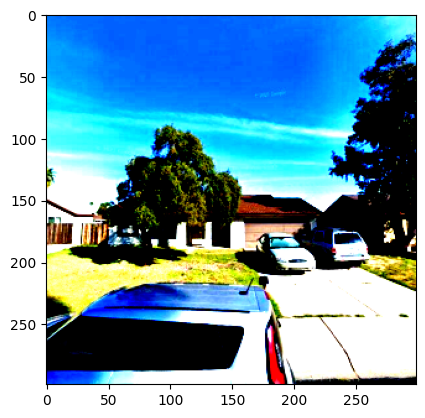

In [26]:
import matplotlib.pyplot as plt

plt.imshow(i[0][0].permute(1,2,0))

In [3]:
for i in inception.children():
    print(i)
    print()

BasicConv2d(
  (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
)

BasicConv2d(
  (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
)

BasicConv2d(
  (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
)

MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)

BasicConv2d(
  (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
)

BasicConv2d(
  (conv): Conv2d(80, 192, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
)

MaxPool2d(kernel_size=3, st

In [27]:
type(inception)

torchvision.models.inception.Inception3

In [4]:
class CityInception(torch.nn.Module):
    def __init__(self, numClasses: int, softmax:bool = True):
        super(CityInception, self).__init__()

        self.inceptionBase = torchvision.models.inception_v3(weights='DEFAULT')
        self.inceptionBase.fc = torch.nn.Linear(in_features=2048, out_features=numClasses)
        for param in list(self.inceptionBase.parameters())[:-1]:
            param.requires_grad = False
        # for param in self.inceptionBase.parameters():
        #     print(param.requires_grad)

        self.softmax = torch.nn.Softmax(dim=-1)

    def forward(self, x):
        # print(x.shape)
        logits = self.inceptionBase(x)
        # print(type(logits))
        # print(logits)
        # print(logits.shape)
        probs = self.softmax(logits.logits)

        return probs






In [5]:
def city_to_vector(city):
    output = np.zeros(shape=(len(city), 10))
    for i in range(len(city)):
        if city[i] == 'Atlanta':
            output[i][0] = 1
        elif city[i] == 'Austin':
            output[i][1] = 1
        elif city[i] == 'Boston':
            output[i][2] = 1
        elif city[i] == 'Chicago':
            output[i][3] = 1
        elif city[i] == 'LosAngeles':
            output[i][4] = 1
        elif city[i] == 'Miami':
            output[i][5] = 1
        elif city[i] == 'NewYork':
            output[i][6] = 1
        elif city[i] == 'Phoenix':
            output[i][7] = 1
        elif city[i] == 'SanFrancisco':
            output[i][8] = 1
        elif city[i] == 'Seattle':
            output[i][9] = 1
    return torch.tensor(output)

In [6]:
numEpochs = 10
batchSize = 128
learningRate = 0.00001

device = "cuda" if torch.cuda.is_available() else "cpu"

transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize(342),
    torchvision.transforms.CenterCrop(299),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))
])

trainDataLoader, testDataLoader = getCitiesDataLoader(batchSize=batchSize, dataParentFolder="./Data/", transforms=transforms)

In [18]:
model = CityInception(10).to(device)


False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
Fals

In [7]:
model = CityInception(10).to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learningRate)

lossPerEpoch = []
for epoch in range(numEpochs):
    lossPerBatch = []
    for image, cities, _, _ in trainDataLoader:
        image = image.to(device)
        cities = city_to_vector(cities).to(device)

        optimizer.zero_grad()
        predicted = model(image)
        loss = criterion(predicted, cities)
        lossPerBatch.append(loss.item())

        loss.backward()
        optimizer.step()

    avgLoss = sum(lossPerBatch) / len(lossPerBatch)
    lossPerEpoch.append()
    print("Loss for epoch {}: {}".format(epoch, avgLoss))



        



Loss for epoch 0: 2.314553054049611
Loss for epoch 0: 2.3135234750807285
Loss for epoch 0: 2.3132506385445595
Loss for epoch 0: 2.3121096305549145
Loss for epoch 0: 2.315526792779565


KeyboardInterrupt: 

In [1]:
def test(inpL: torchvision.models.inception.InceptionOutputs):
    inpL.logits

SyntaxError: incomplete input (420890207.py, line 1)

In [47]:
model(image)

RuntimeError: Expected 3D (unbatched) or 4D (batched) input to conv2d, but got input of size: [128, 1000]

In [7]:
for image, _,_,_ in trainDataLoader:
    inception(image)
    break

In [15]:
# list(inception.parameters())